# Want to reproduce this figure (from `sanity_checks.ipynb`), but make it better:
![caption](images/pixel_effects_sanity_checks.png)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)

#---------------------------------------------------------------------------#
#User imports
import sys
sys.path.append('/Users/fardila/Documents/GitHub/HSC_vs_hydro/')
from functions import *

/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Created TAP+ (v1.0) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


      +------------------------------------------------------------+
      |             Space Telescope Tables Package                 |
      |                  TABLES Version 3.18.3                     |
      |                                                            |
      |   Space Telescope Science Institute, Baltimore, Maryland   |
      |   Copyright (C) 2014 Association of Universities for       |
      |            Research in Astronomy, Inc.(AURA)               |
      |       See stsdas$copyright.stsdas for terms of use.        |
      |         For help, send e-mail to help@stsci.edu            |
      +------------------------------------------------------------+
tables/:
 fitsio/        tbplot/         tobsolete/      ttools/


      +------------------------------------------------------------+
      |       Space Telescope Science Data Analysis System         |
  

In [2]:
illustris_file_orig = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/Illustris/old_files/galaxies_orig.hdf5'
illustris_file_large = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/Illustris/old_files/galaxies_orig_large.hdf5'
illustris_file_highres = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/Illustris/old_files/galaxies_orig_highres.hdf5'
illustris_file_full = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/Illustris/old_files/galaxies_orig_11.2.hdf5'

In [3]:
def get_pixel_scale(file):
    f = h5py.File(file, 'r')
    cat_sh_mstar = np.array(f['cat_sh_mstar'])
    
    map_size = f.attrs['stellar_map_size']
    n_pixels = f.attrs['stellar_map_np']
    f.close()

    pixel_scale = 2 * (map_size/n_pixels)
    
    return  pixel_scale, np.log10(cat_sh_mstar)

In [4]:
pixel_scale_orig, cat_mstar_orig = get_pixel_scale(illustris_file_orig)
pixel_scale_large, cat_mstar_large = get_pixel_scale(illustris_file_large)
pixel_scale_highres, cat_mstar_highres = get_pixel_scale(illustris_file_highres)
pixel_scale_full, cat_mstar_full = get_pixel_scale(illustris_file_full)

In [5]:
#full file has more galaxies, so find indices where each galaxy is the same as the 5 from the other files
full_indices = [list(cat_mstar_full).index(mass) for mass in cat_mstar_orig]

In [6]:
full_indices

[0, 2, 3, 6, 10]

In [7]:
print(cat_mstar_orig)
print(cat_mstar_large)
print(cat_mstar_highres)
print(cat_mstar_full[full_indices])

[12.41485113 12.33545121 12.30699255 12.25874166 12.23647315]
[12.41485113 12.33545121 12.30699255 12.25874166 12.23647315]
[12.41485113 12.33545121 12.30699255 12.25874166 12.23647315]
[12.41485113 12.33545121 12.30699255 12.25874166 12.23647315]


## Get isos

In [8]:
def get_iso2(sim_file, sim_name, gal_n=0):
    
    f = h5py.File(sim_file, 'r')

    try:
        map_stars = np.array(f['map_stars'])
    except:
        map_stars_insitu = np.array(f['map_stars_insitu'])
        map_stars_exsitu = np.array(f['map_stars_exsitu'])
        map_stars = map_stars_exsitu + map_stars_insitu


    map_size = f.attrs['stellar_map_size']
    n_pixels = f.attrs['stellar_map_np']
    pixel_scale=2 * (map_size/n_pixels)

    f.close()

    #make maps
    mass_map_cen = map_stars[gal_n, 0, 1] * (pixel_scale ** 2) # Central
    
    #central pixels
    x0=n_pixels/2.
    y0=n_pixels/2.


    #postage mass
    m_post = np.log10(np.sum(mass_map_cen))


    #ouput maps
    maps_location='/Users/fardila/Documents/GitHub/HSC_vs_hydro/Figures/fits_files/pixel_effects/'

    file_name=sim_name+'_'+str(gal_n)+'_xy'
    fits_prefix = maps_location + file_name

   
    data=mass_map_cen
    save_to_fits(mass_map_cen, fits_prefix + '_cen.fits')
 

    suffix='_cen'

    ###########################################################################
    #get background
    bkg = sep.Background(data, bw=10, bh=10, fw=5, fh=5)
    bkg_subtraced_data = data - bkg

    thresh = 50 * bkg.globalrms
    objects = sep.extract(bkg_subtraced_data, thresh, minarea = 100,
                          deblend_nthresh=24, deblend_cont=0.1)

    #find object closest to image center
    obj = find_closest(objects, x0=x0, y0=y0)

    #ellipse parameters
    theta = obj['theta']
    q = obj['b']/ obj['a']

    a_10, a_30, a_100 = (10. / pixel_scale), (30. / pixel_scale), (100. / pixel_scale)
    b_10, b_30, b_100 =  a_10 * q, a_30 * q, a_100 * q

    ###########################################################################
    #1D masses from galSBP
    try:
        iso, iso_bin = galSBP.galSBP(maps_location+file_name+suffix+'.fits',
                                         galX=x0,
                                         galY=y0,
                                         galQ=q,
                                         galPA=theta* 180. / np.pi,
                                         maxSma=250,
                                         iniSma=50.0,
                                         stage=3,
                                         intMode='median',
                                         ellipStep=0.05,
                                         pix=pixel_scale,
                                         zpPhoto=0.0,
                                         isophote=x_isophote,
                                         xttools=x_ttools,
                                         recenter=True,
                                         savePng=False,
                                         verbose=True)


        ###########################################################################
        iso['sma_kpc'] = iso['sma'] * pixel_scale
        iso['intens_kpc']=iso['intens'] / (pixel_scale**2)

    except ValueError:
        iso = -99.99


    return iso

In [9]:
isos_orig=[]
isos_large=[]
isos_highres=[]
isos_full=[]

for i in range(5):
    print('^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^')
    print('^^^^^^^^GALAXY '+str(i)+'^^^^^^^^^^^^^^')
    print('^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^')

    iso_cen = get_iso2(illustris_file_orig, 'Illustris_orig',gal_n=i)
    isos_orig.append(iso_cen)
    
    iso_cen = get_iso2(illustris_file_large, 'Illustris_large',gal_n=i)
    isos_large.append(iso_cen)
    
    iso_cen = get_iso2(illustris_file_highres, 'Illustris_highres',gal_n=i)
    isos_highres.append(iso_cen)
    
for i in full_indices:
    print('^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^')
    print('^^^^^^^^GALAXY '+str(i)+'^^^^^^^^^^^^^^')
    print('^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^')

    iso_cen = get_iso2(illustris_file_full, 'Illustris_full',gal_n=i)
    isos_full.append(iso_cen)

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^GALAXY 0^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
----------------------------------------------------------------------------------------------------
###      galX, galY :  100.0 100.0
###      galR :  20.0
###      iniSma, maxSma :  50.0 250
###      Stage :  3
###      Step :  0.05
----------------------------------------------------------------------------------------------------
##       Set up the Ellipse configuration
----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
##       Start the Ellipse Run: Attempt  1
----------------------------------------------------------------------------------------------------
###      Origin Image  : /Users/fardila/Documents/GitHub/HSC_vs_hydro/Figures/fits_files/pixel_effects/Illustris_orig_0_xy_cen.fits
###      Input Image   : temp_FZRY8.fits
###     

/Users/fardila/Documents/Github/kungpao/kungpao/galsbp/galSBP.py:1619: RuntimeWarning: divide by zero encountered in log10
  expTime))
/Users/fardila/Documents/Github/kungpao/kungpao/galsbp/galSBP.py:1619: RuntimeWarning: invalid value encountered in log10
  expTime))


----------------------------------------------------------------------------------------------------
###      galX, galY :  100.0 100.0
###      galR :  20.0
###      iniSma, maxSma :  50.0 250
###      Stage :  3
###      Step :  0.05
----------------------------------------------------------------------------------------------------
##       Set up the Ellipse configuration
----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
##       Start the Ellipse Run: Attempt  1
----------------------------------------------------------------------------------------------------
###      Origin Image  : /Users/fardila/Documents/GitHub/HSC_vs_hydro/Figures/fits_files/pixel_effects/Illustris_large_0_xy_cen.fits
###      Input Image   : temp_RKPDQ.fits
###      Output Binary : /Users/fardila/Documents/GitHub/HSC_vs_hydro/Figures/fits_files/pixel_effec

----------------------------------------------------------------------------------------------------
###      Origin Image  : /Users/fardila/Documents/GitHub/HSC_vs_hydro/Figures/fits_files/pixel_effects/Illustris_orig_2_xy_cen.fits
###      Input Image   : temp_095WC.fits
###      Output Binary : /Users/fardila/Documents/GitHub/HSC_vs_hydro/Figures/fits_files/pixel_effects/Illustris_orig_2_xy_cen_ellip_3.bin
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
###     Input background value   :  0.0
###     1-D SBP background value :  8381632.0
###     Current outer background :  8381632.0
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
###      galX, galY :  100.0 100.0
###      galR : 

/Users/fardila/Documents/Github/kungpao/kungpao/galsbp/galSBP.py:577: RuntimeWarning: divide by zero encountered in log10
  sbpOri = zp - 2.5 * np.log10(intensOri / (pixArea * exptime))
/Users/fardila/Documents/Github/kungpao/kungpao/galsbp/galSBP.py:578: RuntimeWarning: divide by zero encountered in log10
  sbpSub = zp - 2.5 * np.log10(intensSub / (pixArea * exptime))
/Users/fardila/Documents/Github/kungpao/kungpao/galsbp/galSBP.py:588: RuntimeWarning: divide by zero encountered in log10
  (pixArea * exptime))
/Users/fardila/Documents/Github/kungpao/kungpao/galsbp/galSBP.py:589: RuntimeWarning: invalid value encountered in subtract
  sbp_err = (sbpSub - sbp_low)


----------------------------------------------------------------------------------------------------
###     Input background value   :  0.0
###     1-D SBP background value :  0.0
###     Current outer background :  0.0
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
###      galX, galY :  250.0 250.0
###      galR :  20.0
###      iniSma, maxSma :  50.0 250
###      Stage :  3
###      Step :  0.05
----------------------------------------------------------------------------------------------------
##       Set up the Ellipse configuration
----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
##       Start the Ellipse Run: Attempt  1
-----------------------------------------------------

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
###     Input background value   :  0.0
###     1-D SBP background value :  290277.5
###     Current outer background :  290277.5
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
###      galX, galY :  250.0 250.0
###      galR :  20.0
###      iniSma, maxSma :  50.0 250
###      Stage :  3
###      Step :  0.05
----------------------------------------------------------------------------------------------------
##       Set up the Ellipse configuration
----------------------------------------------------------------------------------------------------

--------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
###      galX, galY :  100.0 100.0
###      galR :  20.0
###      iniSma, maxSma :  50.0 250
###      Stage :  3
###      Step :  0.05
----------------------------------------------------------------------------------------------------
##       Set up the Ellipse configuration
----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
##       Start the Ellipse Run: Attempt  1
----------------------------------------------------------------------------------------------------
###      Origin Image  : /Users/fardila/Documents/GitHub/HSC_vs_hydro/Figures/fits_files/pixel_effects/Illustris_full_10_xy_cen.fits
###      Input Image   : temp_52NR1.fits
###      Output Binary : /Users/fardila/Documents/GitHub/HSC_vs_hydro/Figures/fits_files/pixel_effec

# Plot 

/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log10


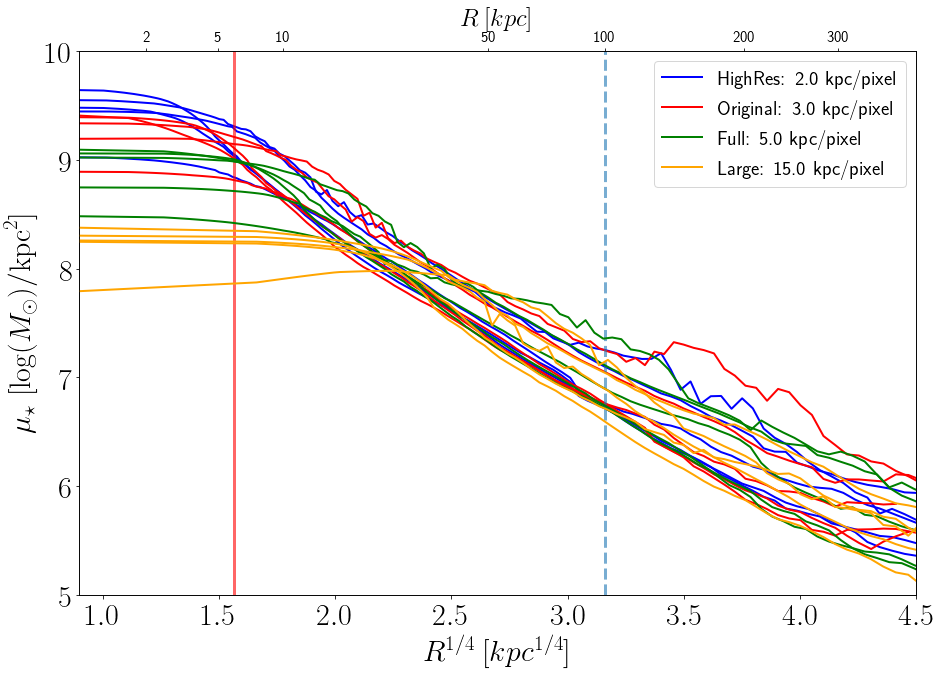

In [29]:
fig = plt.figure(figsize=(15, 10))
ax1 = plt.subplot()

for iso_orig, iso_large, iso_highres, iso_full in zip(isos_orig, isos_large, isos_highres, isos_full):   

        ax1.plot((iso_highres['sma'] * pixel_scale_highres) ** 0.25,
             np.log10(iso_highres['intens'] / (pixel_scale_highres**2.0))+ np.log10(0.7 ** 2.0) , linewidth=2, alpha=1, 
                 label='_nolegend_', zorder=1, c='b')
        
        ax1.plot((iso_orig['sma'] * pixel_scale_orig) ** 0.25,
             np.log10(iso_orig['intens'] / (pixel_scale_orig**2.0))+ np.log10(0.7 ** 2.0) , linewidth=2, alpha=1, 
                 label='_nolegend_', zorder=2, c='r')
        
        ax1.plot((iso_full['sma'] * pixel_scale_full) ** 0.25,
             np.log10(iso_full['intens'] / (pixel_scale_full**2.0))+ np.log10(0.7 ** 2.0) , linewidth=2, alpha=1, 
                 label='_nolegend_', zorder=3, c='g')
            
        ax1.plot((iso_large['sma'] * pixel_scale_large) ** 0.25,
             np.log10(iso_large['intens'] / (pixel_scale_large**2.0))+ np.log10(0.7 ** 2.0) , linewidth=2, alpha=1, 
                 label='_nolegend_', zorder=4, c='orange')

        



# no show lines for legend
ax1.plot([], linewidth=2, alpha=1, label='HighRes: '+str(pixel_scale_highres)+' kpc/pixel', zorder=1, c='b') 
ax1.plot([], linewidth=2, alpha=1, label='Original: '+str(pixel_scale_orig)+' kpc/pixel', zorder=1, c='r') 
ax1.plot([], linewidth=2, alpha=1, label='Full: '+str(pixel_scale_full)+' kpc/pixel', zorder=1, c='g') 
ax1.plot([], linewidth=2, alpha=1, label='Large: '+str(pixel_scale_large)+' kpc/pixel', zorder=1, c='orange') 


######################################################################################################################
# plot details
######################################################################################################################
# X-Y limits
ax1.set_xlim(0.9, 4.5)
ax1.set_ylim(5, 10)

# Labels
ax1.set_xlabel(r'$\log\ (M_{\star}/M_{\odot})$', 
               size=60)
ax1.set_ylabel(r'$\mathrm{d}N/\mathrm{d}\log M_{\star}\ [{\mathrm{Mpc}^{-3}}{\mathrm{dex}^{-1}}]$', 
               size=60)
ax1.tick_params(axis='both', which='major', labelsize=30)

#text label
#ax1.text(1.65, 4.2, r'$11.6<M_{100}<11.8$', size=30)

ax1.legend(fontsize=20)

#add twin x axis in kpc
x1, x2 = ax1.get_xlim()
ax1_twin = ax1.twiny()
ax1_twin.set_xlim(x1, x2)
ax1_twin.figure.canvas.draw()
ax1_twin.xaxis.set_ticks([2**0.25, 5**0.25, 10**0.25, 50**0.25, 100**0.25, 200**0.25, 300**0.25])
ax1_twin.xaxis.set_ticklabels([2, 5, 10, 50, 100, 200, 300])
ax1_twin.tick_params(axis='both', which='major', labelsize=15)
ax1_twin.set_xlabel(r'$R \: [kpc]$', fontsize=25)

######################################################################################################################

#axis labels and vertical lines
ax1.set_xlabel(r'$R^{1/4} \: [kpc^{1/4}]$', fontsize=30)
ax1.set_ylabel(r'$\mu_{\star}\ [\log (M_{\odot})/\mathrm{kpc}^2]$', fontsize=30)
ax1.axvline(100.0 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.6)
ax1.axvline(6.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='r')
ax1.axvline(800.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='r')

######################################################################################################################
#adjustments to ticks and space between subplots

# fig.savefig('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Plots/surface_brightness_Illustris.pdf',
#             dpi=100, format='pdf', bbox_inches='tight')

plt.show()

In [49]:
x1, x2

(0.9, 4.0)

In [50]:
ax1.get_xlim()

(0.9, 4.0)